In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import torch.nn as nn
import torch.nn.functional as F
 
 
class EmotionNet(nn.Module):
    network_config = [32, 32, 'M', 64, 64, 'M', 128, 128, 'M']
 
    def __init__(self, num_of_channels, num_of_classes):
        super(EmotionNet, self).__init__()
        self.features = self._make_layers(num_of_channels, self.network_config)
        self.classifier = nn.Sequential(nn.Linear(6 * 6 * 128, 64),
                                        nn.ELU(True),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(64, num_of_classes))
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=True)
        out = self.classifier(out)
        return out

    # generate the convolutional layers within the network
    def _make_layers(self, in_channels, cfg):
        layers = []
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ELU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

In [11]:
from torch.optim import lr_scheduler
import cv2
 
# if val loss did not go down after numb of epochs,
# reduce the learning rate by factor
class LRScheduler:
 
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience # numb of epochs to wait before updating learning rate
        self.min_lr = min_lr # min learning rate
        self.factor = factor # learning rate to be updated by this factor
        self.lr_scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min",
                                                           patience=self.patience,
                                                           factor=self.factor,
                                                           min_lr=self.min_lr,
                                                           verbose=True)
 
    def __call__(self, validation_loss):
        self.lr_scheduler.step(validation_loss)

class EarlyStopping:
 
    def __init__(self, patience=10, min_delta=0):
        self.early_stop_enabled = False
        self.min_delta = min_delta # min diff between previous and new loss to consider network is improving
        self.patience = patience # numb of epochs to wait before stopping the training
        self.best_loss = None
        self.counter = 0
    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
 
        # check if the training procedure should be stopped
        elif (self.best_loss - validation_loss) < self.min_delta:
            self.counter += 1
            print(f"[INFO] Early stopping: {self.counter}/{self.patience}... \n\n")
 
            if self.counter >= self.patience:
                self.early_stop_enabled = True
                print(f"[INFO] Early stopping enabled")
 
        # reset the early stopping counter
        elif (self.best_loss - validation_loss) > self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0

In [12]:
from torchvision.transforms import RandomHorizontalFlip
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import classification_report
from torchvision.transforms import RandomCrop
from torchvision.transforms import Grayscale
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import torch.nn as nn
import pandas as pd
import argparse
import torch
import math

# initialize the argument parser and establish the arguments required
parser = argparse.ArgumentParser()
parser.add_argument('-m', '--model', type=str, help='Path to save the trained model')
parser.add_argument('-p', '--plot', type=str, help='Path to save the loss/accuracy plot')
parser.add_argument("-f", required=False)
args = vars(parser.parse_args())
 
# configure the device to use for training the model, either gpu or cpu
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"[INFO] Current training device: {device}")

# image preprocessing 
train_transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    RandomHorizontalFlip(),
    RandomCrop((48, 48)),
    ToTensor()
])
 
test_transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    ToTensor()
])
 
# load all the images within the specified folder and apply different augmentation
train_data = datasets.ImageFolder('/content/drive/My Drive/CNN_data_aps360/train', transform=train_transform)
test_data = datasets.ImageFolder('/content/drive/My Drive/CNN_data_aps360/test', transform=test_transform)
 
classes = train_data.classes # class labels
num_of_classes = len(classes) # total numb of classes

# split train samples into train/valid
num_train_samples = len(train_data)
train_size = math.floor(num_train_samples * 0.9)
val_size = math.ceil(num_train_samples * 0.1)
train_data, val_data = random_split(train_data, [train_size, val_size])
 
# modify the data transform applied towards the validation set
val_data.dataset.transforms = test_transform

In [13]:
# get the labels within the training set
train_classes = [label for _, label in train_data]

[INFO] Training the model...
[INFO] epoch: 1/100
train loss: 2.129  .. train accuracy: 0.184
val loss: 2.284  .. val accuracy: 0.246

[INFO] epoch: 2/100
train loss: 1.994  .. train accuracy: 0.225
val loss: 2.238  .. val accuracy: 0.254

[INFO] epoch: 3/100
train loss: 1.888  .. train accuracy: 0.266
val loss: 2.131  .. val accuracy: 0.317

[INFO] epoch: 4/100
train loss: 1.836  .. train accuracy: 0.294
val loss: 2.174  .. val accuracy: 0.328

[INFO] Early stopping: 1/10... 


[INFO] epoch: 5/100
train loss: 1.743  .. train accuracy: 0.329
val loss: 2.175  .. val accuracy: 0.336

[INFO] Early stopping: 2/10... 


[INFO] epoch: 6/100
train loss: 1.702  .. train accuracy: 0.351
val loss: 2.006  .. val accuracy: 0.344

[INFO] epoch: 7/100
train loss: 1.626  .. train accuracy: 0.384
val loss: 2.062  .. val accuracy: 0.344

[INFO] Early stopping: 1/10... 


[INFO] epoch: 8/100
train loss: 1.632  .. train accuracy: 0.376
val loss: 1.932  .. val accuracy: 0.369

[INFO] epoch: 9/100
train los

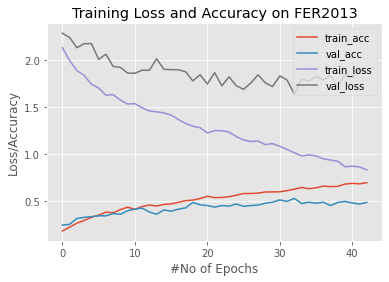

In [14]:
# count each labels within each classes
class_count = Counter(train_classes)
 
# weights to be applied on each category
class_weight = torch.Tensor([len(train_classes) / c for c in pd.Series(class_count).sort_index().values])
 
sample_weight = [0] * len(train_data)
for idx, (image, label) in enumerate(train_data):
    sample_weight[idx] = class_weight[label] # set default sample weight to its class weight
 
# randomly sample labels from train data
sampler = WeightedRandomSampler(weights=sample_weight, num_samples=len(train_data),
                                replacement=True)
 
train_dataloader = DataLoader(train_data, batch_size=64, sampler=sampler)
val_dataloader = DataLoader(val_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# initializing the model
model = EmotionNet(num_of_channels=1, num_of_classes=num_of_classes)
#model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
 
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
 
# numb of steps in each epoch for train and val
train_steps = len(train_dataloader.dataset) // 64
val_steps = len(val_dataloader.dataset) // 64
 
# initialize a dictionary to save the training history
history = {
    "train_acc": [],
    "train_loss": [],
    "val_acc": [],
    "val_loss": []
}

# iterate through the epochs
print(f"[INFO] Training the model...")
#start_time = datetime.now()
 
for epoch in range(0, 100):
 
    print(f"[INFO] epoch: {epoch + 1}/{100}")
 
    """
    Training
    """
    model.train()
 
    total_train_loss = 0
    total_val_loss = 0

    # number of correct predictions
    train_correct = 0
    val_correct = 0
 
    # iterate through the train data
    for (data, target) in train_dataloader:
        # move the data into the device used for training,
        #data, target = data.to(device), target.to(device)
 
        # forward pass
        predictions = model(data)
        loss = criterion(predictions, target)
 
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_loss += loss
        train_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()

    """
    Validation
    """
    model.eval()  # disable dropout and dropout layers
 
    with torch.set_grad_enabled(False): #prevents pytorch from calculating the gradients
 
        # iterate through the validation set
        for (data, target) in val_dataloader:
            # move the data into the device used for testing
            #data, target = data.to(device), target.to(device)
 
            # forward pass
            predictions = model(data)
            loss = criterion(predictions, target)
 
            total_val_loss += loss
            val_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()

    # losses
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps
 
    # accuracies
    train_correct = train_correct / len(train_dataloader.dataset)
    val_correct = val_correct / len(val_dataloader.dataset)
 
    # print model training and validation records
    print(f"train loss: {avg_train_loss:.3f}  .. train accuracy: {train_correct:.3f}")
    print(f"val loss: {avg_val_loss:.3f}  .. val accuracy: {val_correct:.3f}", end='\n\n')
 
    # update the training and validation results
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    history['train_acc'].append(train_correct)
    history['val_loss'].append(avg_val_loss.cpu().detach().numpy())
    history['val_acc'].append(val_correct)
 
    # execute the learning rate scheduler and early stopping
    validation_loss = avg_val_loss.cpu().detach().numpy()
    lr_scheduler(validation_loss)
    early_stopping(validation_loss)
 
    # stop the training procedure due to no improvement while validating the model
    if early_stopping.early_stop_enabled:
        break
  
# plot the training loss and accuracy overtime
plt.style.use("ggplot")
plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel("#No of Epochs")
plt.title('Training Loss and Accuracy on FER2013')
plt.legend(loc='upper right')
#plt.savefig(args['plot'])

In [15]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data: 
      output = model(imgs)
        
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total

print(f"Testing accuracy: {get_accuracy(model, test_dataloader)}")

Testing accuracy: 0.47815533980582525
